In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Jan 28 17:44:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:03:00.0 Off |                  Off |
| 30%   31C    P2              66W / 450W |   7289MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive4_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = None
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 0.001953125
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/home/save/lse/train_dalle/train01.29-1_1e-0/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel to create 3 channels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3 channels
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


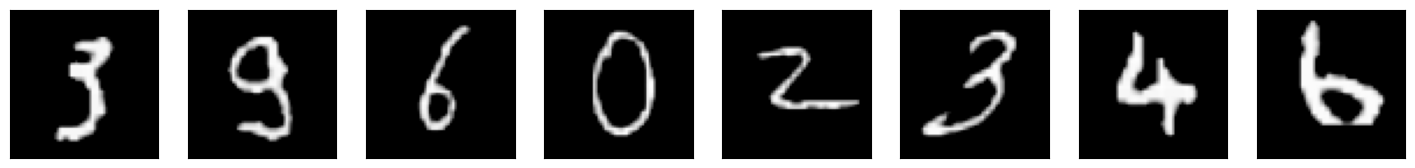

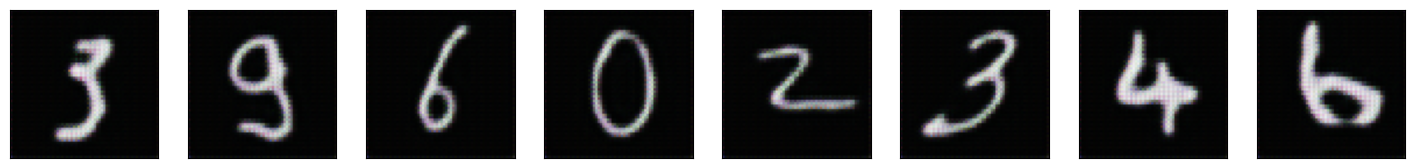

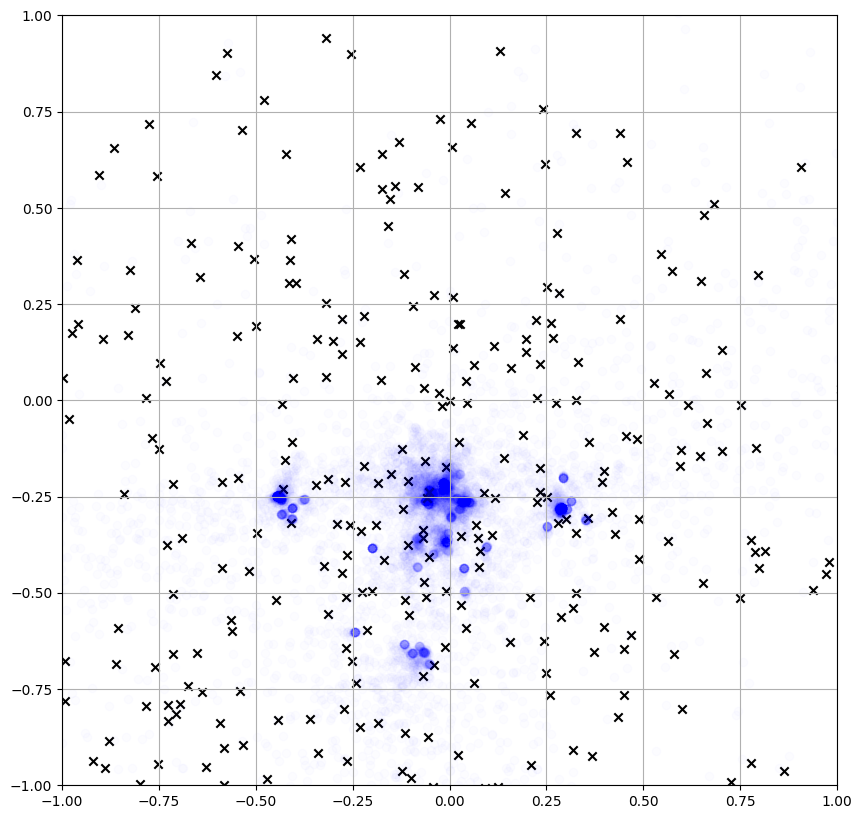

1100 lse_loss 11.733342170715332
1100 commit_loss 0.7446443438529968
1100 recon_loss 0.8426151275634766
1200 lse_loss 11.788667678833008
1200 commit_loss 0.7183490991592407
1200 recon_loss 0.8459042310714722


lse_loss 14.403974533081055
commit_loss 0.07513892650604248
recon_loss 0.009524945169687271
702
lse_loss 14.494900703430176
commit_loss 0.0841049998998642
recon_loss 0.01112915389239788
703
lse_loss 14.45999526977539
commit_loss 0.07446896284818649
recon_loss 0.011186162941157818
704
lse_loss 14.427091598510742
commit_loss 0.07831920683383942
recon_loss 0.011774875223636627
705
lse_loss 14.47207260131836
commit_loss 0.07433738559484482
recon_loss 0.01049290131777525
706
lse_loss 14.491397857666016
commit_loss 0.08337293565273285
recon_loss 0.01126925554126501
707
lse_loss 14.458318710327148
commit_loss 0.07892859727144241
recon_loss 0.010972408577799797
708
lse_loss 14.415197372436523
commit_loss 0.07819147408008575
recon_loss 0.011275703087449074
709
lse_loss 14.452611923217773
commit_loss 0.0754324272274971
recon_loss 0.011321017518639565
710
lse_loss 14.467004776000977
commit_loss 0.07590395957231522
recon_loss 0.011100241914391518
711
lse_loss 14.486394882202148
commit_loss 0.07485

789
lse_loss 14.684806823730469
commit_loss 0.08360384404659271
recon_loss 0.010584123432636261
790
lse_loss 14.704402923583984
commit_loss 0.0789542943239212
recon_loss 0.01047141756862402
791
lse_loss 14.672389030456543
commit_loss 0.08156746625900269
recon_loss 0.010746544227004051
792
lse_loss 14.728923797607422
commit_loss 0.08632256090641022
recon_loss 0.010776219889521599
793
lse_loss 14.739662170410156
commit_loss 0.08967937529087067
recon_loss 0.012865213677287102
794
lse_loss 14.730140686035156
commit_loss 0.0928141176700592
recon_loss 0.011869776993989944
795
lse_loss 14.691810607910156
commit_loss 0.090446338057518
recon_loss 0.010929455980658531
796
lse_loss 14.678939819335938
commit_loss 0.08146528154611588
recon_loss 0.010281304828822613
797
lse_loss 14.716601371765137
commit_loss 0.08751857280731201
recon_loss 0.012044383212924004
798
lse_loss 14.651908874511719
commit_loss 0.07846800982952118
recon_loss 0.01168169267475605
799
lse_loss 14.743728637695312
commit_loss 0.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            distance_p = linear(1, 0.2, step, 0, 1000*1000)
            data = model(data, distance_p=distance_p)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()

        if step % 100 == 0:
            for key in loss_dict:
                writer.add_scalar(key, np.mean(loss_dict[key]), step)
                print(step, key, np.mean(loss_dict[key]))
            
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')